<a href="https://colab.research.google.com/github/muhammadalihussnain/Volume_Controller/blob/master/bert_transforming_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# bert-transforming-with-bert

Use the "Run" button to execute the code.

In [65]:
print('Hello World')

Hello World


In [66]:
!pip install -qq transformers

In [67]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
df= pd.read_csv('/content/drive/MyDrive/reviews.csv')

df.content.isnull().sum()
df.score.isnull().sum()

0

In [70]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'sortOrder', 'appId'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Reviews')

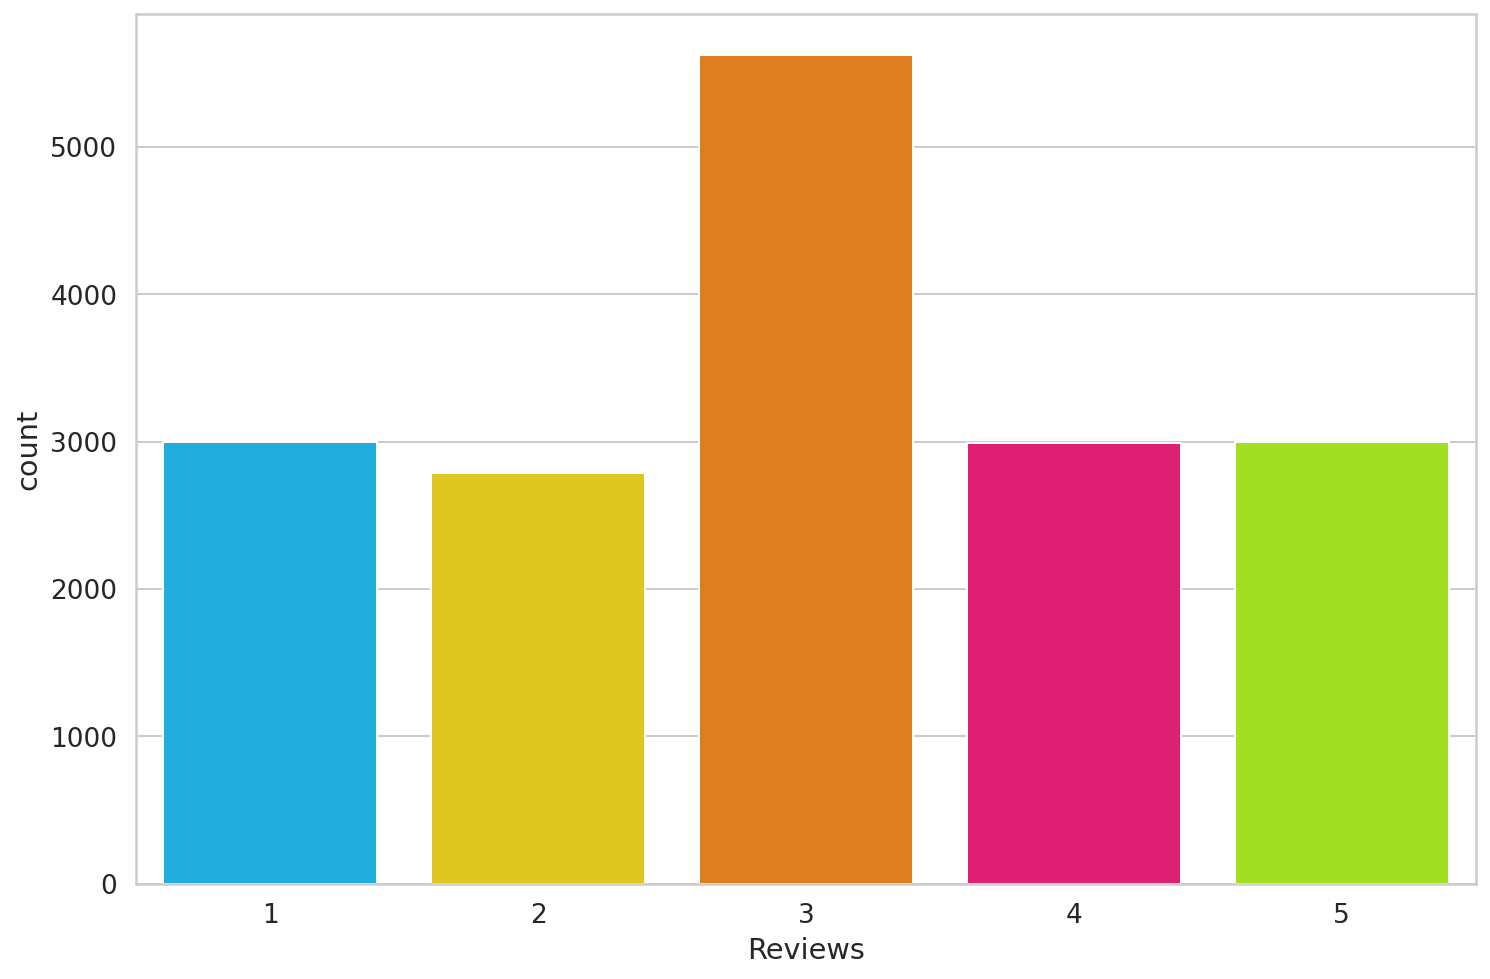

In [71]:
sns.countplot(df.score)
plt.xlabel('Reviews')

In [72]:
conditions= [(df.score<=2),(df.score==3),(df.score>3)]
choices= [0,1,2]
df['score'] =np.select(conditions,choices)
df.score.value_counts()

2    5990
0    5786
1    5622
Name: score, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Reviews')

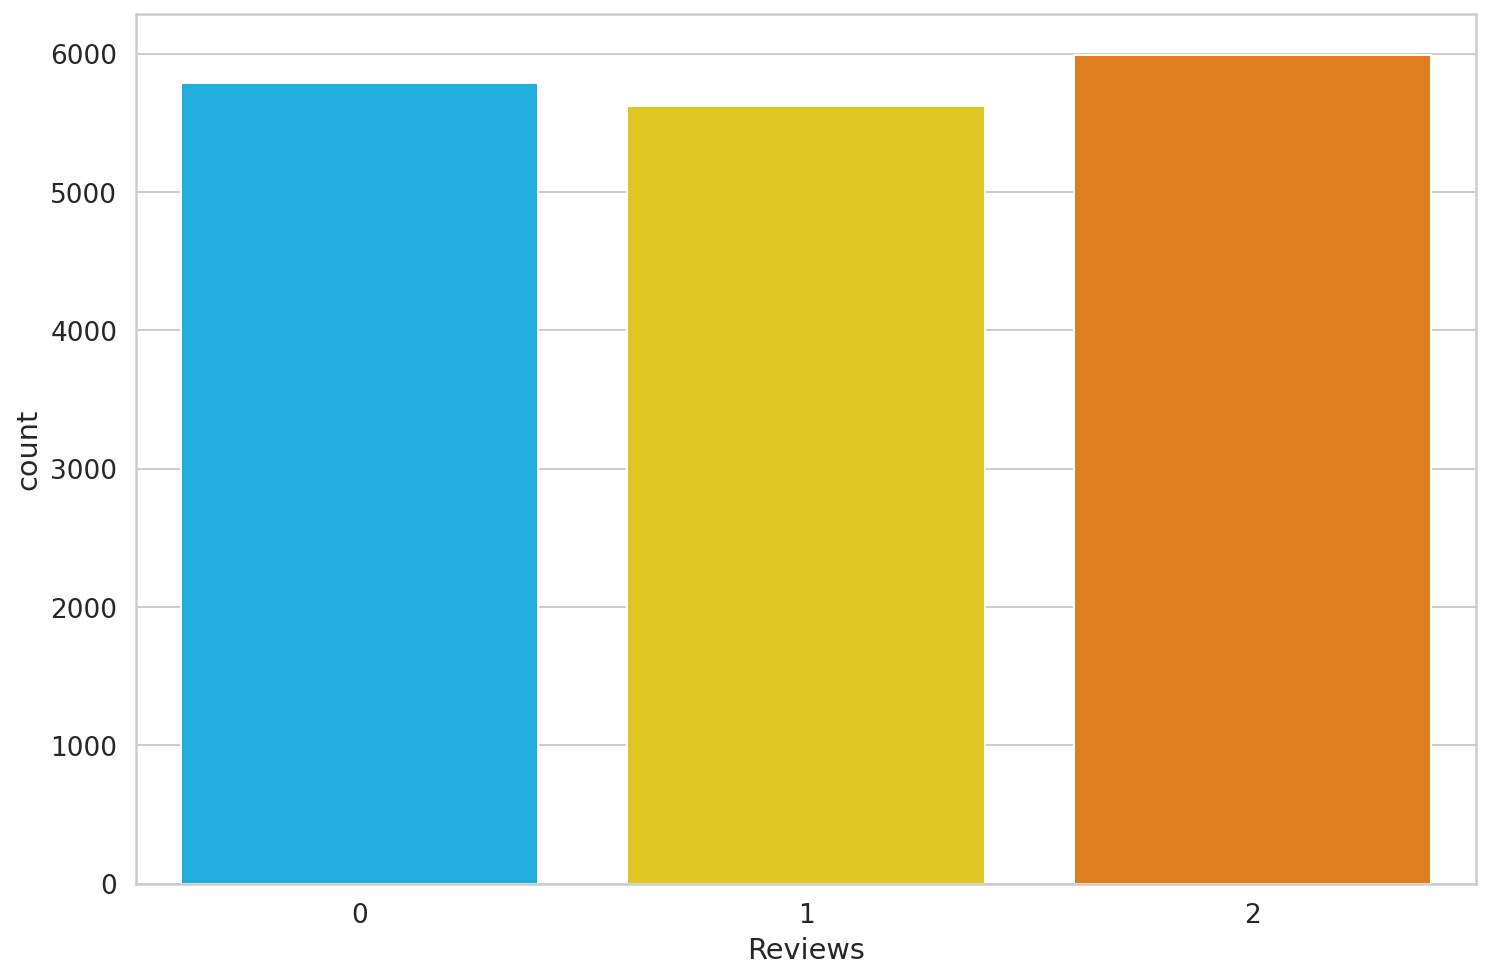

In [73]:

sns.countplot(df.score)
plt.xlabel('Reviews')

In [74]:
PRE_TRAINED_MODEL =   'bert-base-uncased'
tokenizer= BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [75]:
simple_text = "hi how are you i think you are find "
tokens = tokenizer.tokenize(simple_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"simple_text:{simple_text}")
print(f'Tokens:{tokens}')
print(f"token_ids:{token_ids}")

simple_text:hi how are you i think you are find 
Tokens:['hi', 'how', 'are', 'you', 'i', 'think', 'you', 'are', 'find']
token_ids:[7632, 2129, 2024, 2017, 1045, 2228, 2017, 2024, 2424]


In [76]:
print(tokenizer.sep_token,tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[PAD] 0


In [77]:
encoding = tokenizer.encode_plus(
                                simple_text,
                                max_length=32,
                                add_special_tokens=True,
                                return_token_type_ids=False,
                                return_attention_mask=True,
                                pad_to_max_length=True,
                                return_tensor=True)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_tensor': True} not recognized.


dict_keys(['input_ids', 'attention_mask'])

In [78]:
print(encoding.input_ids)
print(encoding.attention_mask)
print(len(encoding['input_ids']))
print(len(encoding['attention_mask']))

[101, 7632, 2129, 2024, 2017, 1045, 2228, 2017, 2024, 2424, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
32
32


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


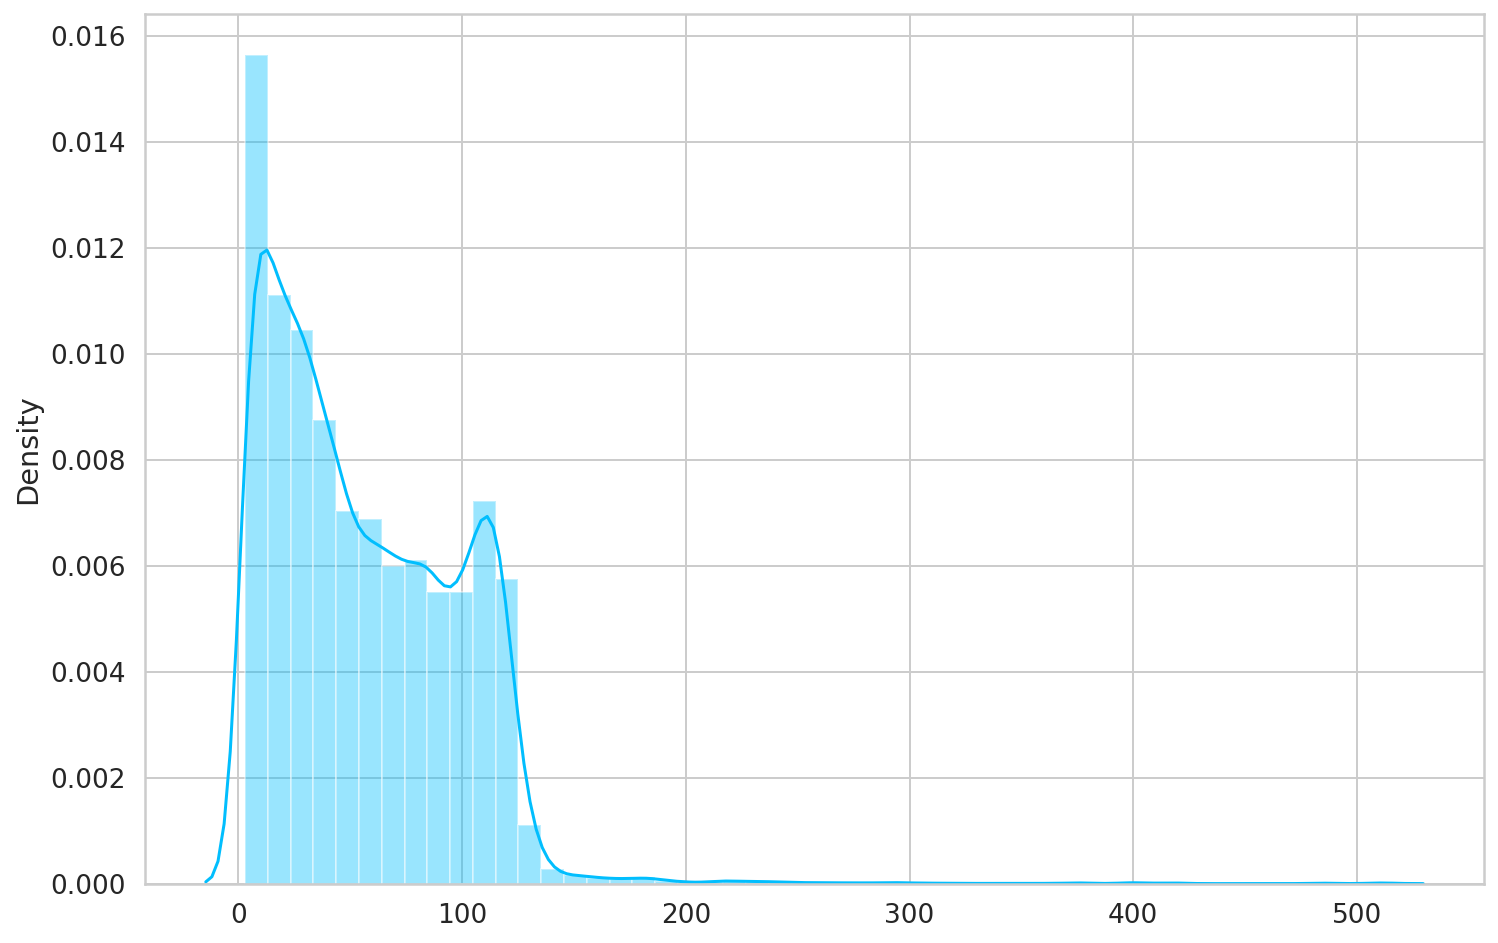

In [79]:
len_tokens=[]
for text in df.content:
  tokens= tokenizer.encode(text,max_length=512)
  len_tokens.append(len(tokens))
sns.distplot(len_tokens)

In [80]:
class GPReviews(Dataset):
  def __init__(self,reviews,targets,tokenizer,max_length):
    self.reviews=reviews
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length


  def __len__(self):
    return len(self.reviews)
  
  def __getitem__( self, index):
    
    review=str(self.reviews[index])
    target=self.targets[index]
    encoding = self.tokenizer.encode_plus(review,
                                max_length=self.max_length,
                                add_special_tokens=True,
                                return_token_type_ids=False,
                                return_attention_mask=True,
                                pad_to_max_length=True,
                                return_tensors='pt')
    return {
        'Review_text':review,
        "encoding_Ids":encoding['input_ids'].flatten(),
        "attention_mask":encoding['attention_mask'].flatten(),
        "Target":torch.tensor(target,dtype=torch.long)
            }

In [81]:
train_df,test_df= train_test_split(df,test_size=.15,random_state=42)
val_df,test_df= train_test_split(test_df,train_size=.5,random_state=42)
print(train_df.shape,val_df.shape,test_df.shape)

(14788, 12) (1305, 12) (1305, 12)


In [82]:
def create_data_loader(data,tokenizer,batch_size,max_len):
  ds=GPReviews(
      reviews=data.content.to_numpy(),
      targets = data.score.to_numpy(),
      tokenizer=tokenizer,
      max_length=max_len
  )
  return DataLoader(ds,batch_size=batch_size,num_workers=4)



In [83]:
PRE_TRAINED_MODEL_NAME='bert-base-cased'
TOKENIZER=BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
BATCH_SIZE=16
MAX_LEN=160
NUM_EPOCHS=10


In [84]:
TRAIN_LOADER=create_data_loader(train_df,TOKENIZER,BATCH_SIZE,MAX_LEN)
VAL_LOADER=create_data_loader(val_df,TOKENIZER,BATCH_SIZE,MAX_LEN)
TEST_LOADER=create_data_loader(test_df,TOKENIZER,BATCH_SIZE,MAX_LEN)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [85]:
data=next(iter(TRAIN_LOADER))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

dict_keys(['Review_text', 'encoding_Ids', 'attention_mask', 'Target'])

In [86]:
model=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
output=model(data['encoding_Ids'],data['attention_mask'])
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [88]:
model.config.hidden_size

768

In [89]:
class SentimentClassifier(nn.Module):
  def __init__(self,n_classes):
    super(SentimentClassifier,self).__init__()
    self.bert=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop=nn.Dropout(p=0.3)
    self.linear=nn.Linear(model.config.hidden_size,n_classes)
    self.softmax=nn.Softmax(dim=1)

  def forward(self,input_ids,attention_mask):
    output=self.bert(input_ids,attention_mask)
    output=self.drop(output[1])
    output = self.linear(output)
    return self.softmax(output)


In [90]:
my_model = SentimentClassifier(3)
input_ids=data['encoding_Ids'].to(device)
attention_mask=data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)
my_model=my_model.to(device)
print(type(input_ids),type(attention_mask))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 160])
torch.Size([16, 160])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [91]:
output=my_model(data['encoding_Ids'].to(device),data['attention_mask'].to(device))
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(TRAIN_LOADER) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [92]:
from transformers.models.layoutlmv2.tokenization_layoutlmv2 import LAYOUTLMV2_ENCODE_PLUS_ADDITIONAL_KWARGS_DOCSTRING
def train_epoch(data,model,device,optimizer,loss_fn,scheduler,n_examples):

  model.train()
  losses=[]
  correct_preds=0

  for d in data:

    input_ids=d['encoding_Ids'].to(device)
    attention_mask=d['attention_mask'].to(device)
    target=d['Target'].to(device)


    output=model(input_ids,attention_mask)  
     
    _,preds=torch.max(output,dim=1)
    loss=loss_fn(output,target)

    losses.append(loss.item())
    correct_preds+=torch.sum(preds==target)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_preds.double() / n_examples, np.mean(losses)


In [93]:
def val_epoch(data,model,device,optimizer,loss_fn,scheduler,n_examples):

  model.eval()
  losses=[]
  correct_preds=0
  with torch.no_grad():
      for d in data:

          input_ids=d['encoding_Ids'].to(device)
          attention_mask=d['attention_mask'].to(device)
          target=d['Target'].to(device)


          output=model(input_ids,attention_mask)  
          
          _,preds=torch.max(output,dim=1)
          loss=loss_fn(output,target)

          losses.append(loss.item())
          correct_preds+=torch.sum(preds==target)
         
  return correct_preds.double() / n_examples, np.mean(losses)

In [ ]:
history=defaultdict(list)
for epoch in range(NUM_EPOCHS):
  print(f"{epoch+1}//{NUM_EPOCHS}")
  print('-'*200)
  train_accuracy,train_loss=train_epoch(TRAIN_LOADER,my_model,device,optimizer,loss_fn,scheduler,len(train_df))
  print(f"train_accuracy:{train_accuracy}          train_loss:{train_loss}")

  val_accuracy,val_loss=train_epoch(VAL_LOADER,my_model,device,optimizer,loss_fn,scheduler,len(val_df))
  print(f"Val_accuracy:{val_accuracy}          Val_loss:{val_loss}")
  history['train_acc'].append(train_accuracy)
  history['val_accuracy'].append(val_accuracy)
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
 


1//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to ma

train_accuracy:0.3341222612929402          train_loss:1.103813432100657


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val_accuracy:0.3210727969348659          Val_loss:1.1056172426153974
val_accuracty:0.3210727969348659       val_loss::1.1056172426153974
2//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

train_accuracy:0.33648904517176087          train_loss:1.1033695025057406


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val_accuracy:0.34406130268199236          Val_loss:1.1049374967086605
val_accuracty:0.34406130268199236       val_loss::1.1049374967086605
3//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

train_accuracy:0.3320935893968082          train_loss:1.1043607318723523


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val_accuracy:0.34099616858237547          Val_loss:1.1022972842542136
val_accuracty:0.34099616858237547       val_loss::1.1022972842542136
4//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

train_accuracy:0.3314173654314309          train_loss:1.104296630910925


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val_accuracy:0.34099616858237547          Val_loss:1.1039548516273499
val_accuracty:0.34099616858237547       val_loss::1.1039548516273499
5//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

train_accuracy:0.3345279956721666          train_loss:1.1034504899463138


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val_accuracy:0.3578544061302682          Val_loss:1.0985286337573354
val_accuracty:0.3578544061302682       val_loss::1.0985286337573354
6//10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

train_accuracy:0.3351365972410062          train_loss:1.103488125027837


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s